# 수입 우범화물 선별 - MLPClassifier 모델

# 1. 분석 환경 설정 및 데이터 로딩<a id='id1'></a> 

In [1]:
# 패키지 로딩
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from difflib import SequenceMatcher
import warnings
warnings.filterwarnings(action='ignore')
import platform
        
# 한글폰트 적용
if platform.system() == 'Darwin': #맥
        plt.rc('font', family='AppleGothic') 
    
plt.rcParams['axes.unicode_minus'] = False #한글 폰트 사용시 마이너스 폰트 깨짐 해결

In [2]:
# 수입 데이터 로딩 (가상데이터)
df_train = pd.read_csv('/Users/mini/Desktop/train.csv')
df_test = pd.read_csv('/Users/mini/Desktop/test.csv')
df_submission = pd.read_csv('/Users/mini/Desktop/submission.csv')

# 2. 데이터 전처리 <a id='id2'></a>

## 2.1. 데이터 셋 확인

In [3]:
# 데이터 사이즈 확인
df_train.shape, df_test.shape, df_submission.shape

((76837, 24), (81058, 21), (23163, 2))

In [4]:
# 불필요한 변수 삭제
del df_train['검사결과코드']
del df_train['핵심적발']

In [5]:
# submission.csv 칼럼 확인
df_submission.columns

Index(['신고번호', '우범여부'], dtype='object')

In [6]:
df_submission.head(3)

,신고번호,우범여부
0,71490948,0
1,44137011,0
2,73320079,0


## 2.1.1 결측치 확인

In [7]:
#결측치 확인
df_train.isnull().sum()

신고번호            0
신고일자            0
통관지세관부호         0
신고인부호           0
수입자부호           8
해외거래처부호     26293
특송업체부호      51731
수입통관계획코드        0
수입신고구분코드        0
수입거래구분코드        0
수입종류코드          0
징수형태코드          0
신고중량(KG)        0
과세가격원화금액        0
운송수단유형코드        0
반입보세구역부호        0
HS10단위부호        0
적출국가코드          0
원산지국가코드         0
관세율구분코드         0
관세율             0
우범여부            0
dtype: int64

In [8]:
df_test.isnull().sum()

신고번호        57895
신고일자        57895
통관지세관부호     57895
신고인부호       57895
수입자부호       57896
해외거래처부호     65569
특송업체부호      73325
수입통관계획코드    57895
수입신고구분코드    57895
수입거래구분코드    57895
수입종류코드      57895
징수형태코드      57895
신고중량(KG)    57895
과세가격원화금액    57895
운송수단유형코드    57895
반입보세구역부호    57895
HS10단위부호    57895
적출국가코드      57895
원산지국가코드     57895
관세율구분코드     57895
관세율         57895
dtype: int64

In [9]:
# 한 데이터당 NaN값 6개 이상인 데이터 삭제

df_train = df_train.dropna(thresh=6)
df_test = df_test.dropna(thresh=6)

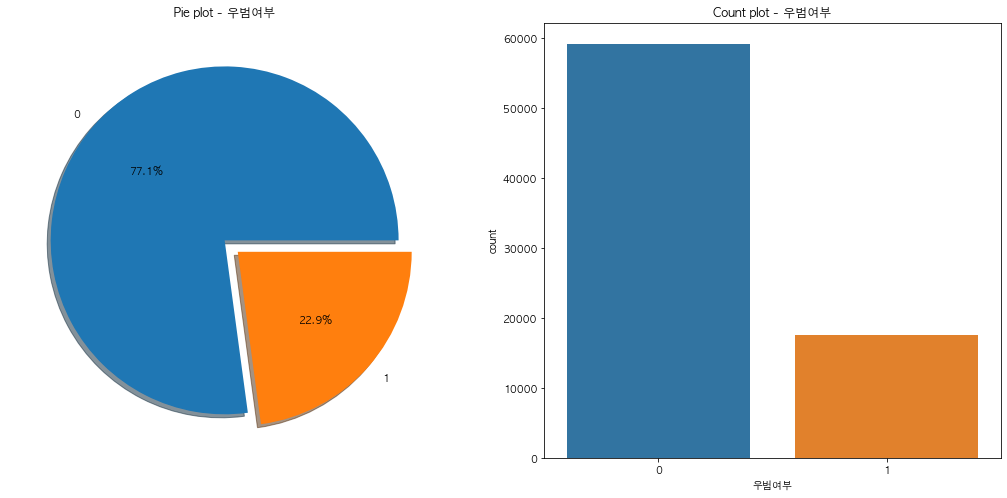

In [10]:
# Target Label, '우범여부' 비율 확인

f, ax = plt.subplots(1, 2, figsize=(18, 8))

df_train['우범여부'].value_counts().plot.pie(explode=[0, 0.1], autopct='%1.1f%%', ax=ax[0], shadow=True)
ax[0].set_title('Pie plot - 우범여부')
ax[0].set_ylabel('')
sns.countplot('우범여부', data=df_train, ax=ax[1])
ax[1].set_title('Count plot - 우범여부')

plt.show()

## 2.2. 변수별 우범여부 관계 확인

<AxesSubplot:xlabel='날짜_월'>

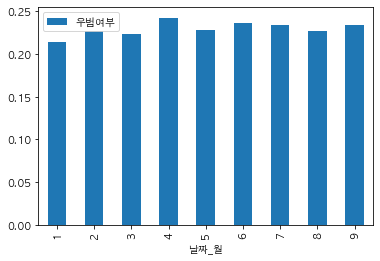

In [11]:
# 신고월별 우범여부 관계
df_train['신고일자'] = pd.to_datetime(df_train['신고일자'])
df_train['날짜_월'] = df_train['신고일자'].dt.month

df_test['신고일자'] = pd.to_datetime(df_test['신고일자'])
df_test['날짜_월'] = df_test['신고일자'].dt.month

df_train[['날짜_월', '우범여부']].groupby(['날짜_월'], as_index=True).mean().plot.bar()

# 월별 균일한 우범여부 -> 신고일자 칼럼 삭제

<AxesSubplot:xlabel='통관지세관부호'>

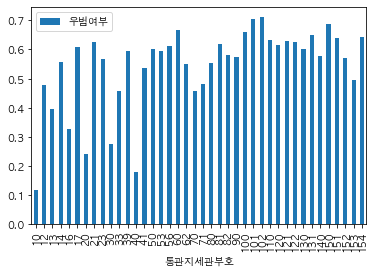

In [12]:
# 통관지세관부호별 우범여부 
df_train[['통관지세관부호', '우범여부']].groupby(['통관지세관부호'], as_index=True).mean().plot.bar()

#지역별로 그룹핑

<AxesSubplot:xlabel='신고인부호'>

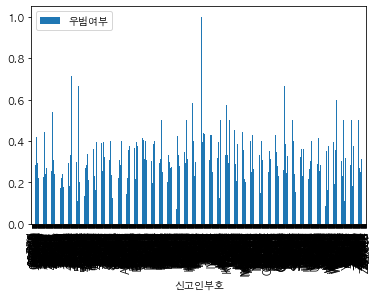

In [13]:
# 신고인부호별 우범여부 
df_train[['신고인부호', '우범여부']].groupby(['신고인부호'], as_index=True).mean().plot.bar()

# 고차원 데이터 -> 신고인부호 칼럼 삭제

<AxesSubplot:xlabel='수입자부호'>

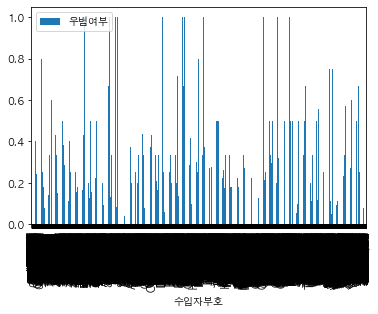

In [14]:
# 수입자부호별 우범여부 
df_train[['수입자부호', '우범여부']].groupby(['수입자부호'], as_index=True).mean().plot.bar()

# 고차원 데이터 -> 수입자부호 칼럼 삭제

<AxesSubplot:xlabel='해외거래처부호'>

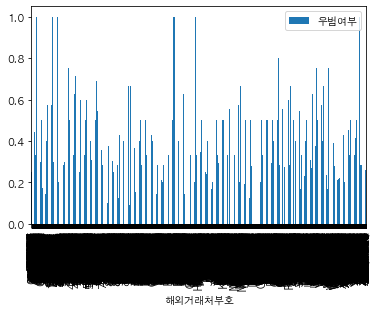

In [15]:
# 해외거래처부호별 우범여부 
df_train[['해외거래처부호', '우범여부']].groupby(['해외거래처부호'], as_index=True).mean().plot.bar()

# 고차원 데이터 -> 해외거래처부호 칼럼 삭제

<AxesSubplot:xlabel='특송업체부호'>

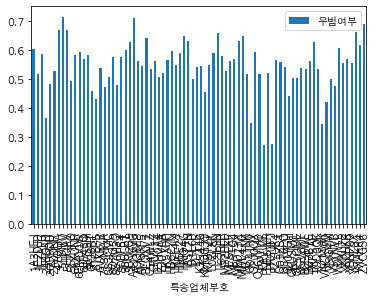

In [16]:
df_train[['특송업체부호', '우범여부']].groupby(['특송업체부호'], as_index=True).mean().plot.bar()

# 특송업체부호는 앞서 결측치 확인 시 NaN값이 많았으므로 특송업체부호가 존재하는지 안하는지를
# 1과 0으로 이진화 

<AxesSubplot:xlabel='수입거래구분코드'>

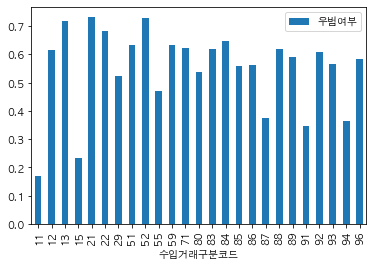

In [17]:
# 수입거래구분코드별 우범여부 
df_train[['수입거래구분코드', '우범여부']].groupby(['수입거래구분코드'], as_index=True).mean().plot.bar()

# 우범률이 적은 데이터끼리 그룹핑

<AxesSubplot:xlabel='운송수단유형코드'>

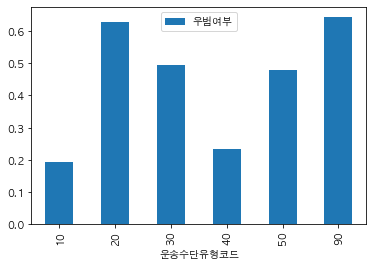

In [18]:
#운송수단유형코드별 우범여부
df_train[['운송수단유형코드', '우범여부']].groupby(['운송수단유형코드'], as_index=True).mean().plot.bar()

# 모델 학습 -> 예측 -> 성능 확인 결과 성능에 큰 영향을 미치지 않아 삭제 

<AxesSubplot:xlabel='반입보세구역부호'>

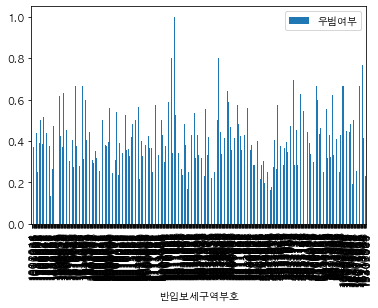

In [19]:
#반입보세구역부호별 우범여부
df_train[['반입보세구역부호', '우범여부']].groupby(['반입보세구역부호'], as_index=True).mean().plot.bar()

# 고차원 데이터 -> 반입보세구역보호 칼럼 삭제 

<AxesSubplot:xlabel='적출국가코드'>

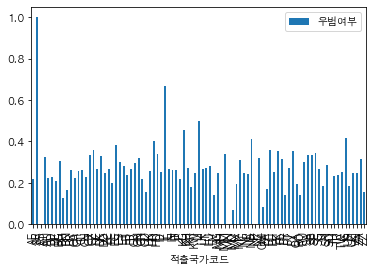

In [20]:
#적출국가코드별 우범여부
df_train[['적출국가코드', '우범여부']].groupby(['적출국가코드'], as_index=True).mean().plot.bar()

# 고차원 데이터 -> 반입보세구역보호 칼럼 삭제 

<AxesSubplot:xlabel='원산지국가코드'>

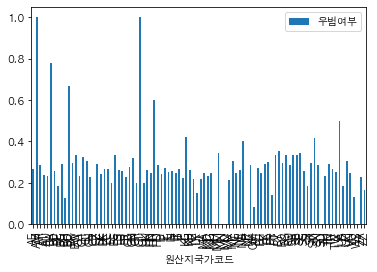

In [21]:
#원산지국가코드별 우범여부
df_train[['원산지국가코드', '우범여부']].groupby(['원산지국가코드'], as_index=True).mean().plot.bar()

# 고차원 데이터 -> 반입보세구역보호 칼럼 삭제 

<AxesSubplot:xlabel='관세율구분코드'>

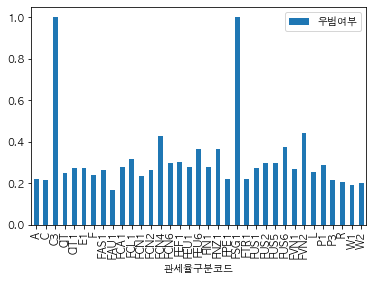

In [22]:
#관세율구분코드별 우범여부
df_train[['관세율구분코드', '우범여부']].groupby(['관세율구분코드'], as_index=True).mean().plot.bar()

# 관세율과 과세가격원화금액 칼럼 있어서 관세율구분코드는 삭제

In [23]:
df_train.head(2)

,신고번호,신고일자,통관지세관부호,신고인부호,수입자부호,해외거래처부호,특송업체부호,수입통관계획코드,수입신고구분코드,수입거래구분코드,...,과세가격원화금액,운송수단유형코드,반입보세구역부호,HS10단위부호,적출국가코드,원산지국가코드,관세율구분코드,관세율,우범여부,날짜_월
0,57298928,2020-01-01,121,2O5A2,82ZHWNL,NaN,TQ18AK,D,B,15,...,5397.965738,10,2106003,8481900000,US,US,A,8.0,1,1
1,85092852,2020-01-01,30,305K5,5IS70LE,NaN,NaN,C,B,11,...,573097.182500,40,4077010,2106909099,US,US,A,8.0,0,1


## 2.2. 수치형 변수 및 범주형 변수 지정 및 각 변수 전처리 

In [24]:
# 통관지세관부호 데이터 수 및 지역별로 그룹핑
def category_region(x):
    if x == 10 or x== 41 or x==130:
        return '서울특별시'
    elif x == 40 or x==13 or x==20 or x == 23:
        return '인천광역시'
    elif x == 30 or x == 37 or x == 39 or x == 140:
        return '부산광역시'
    elif x == 11 or x==12 or x== 14 or x ==16 or x==17 or x== 21 or x==131:       
        return '경기도'
    elif x==100 or x== 101 or x== 102 or x== 103:
        return '강원도'
    elif x==84 or x== 152 or  x==154:
        return '충청남도'
    elif x==151 or x==154:
        return '충청북도'
    elif x==60 or x==62 or x==70:
        return '전라남도'
    elif x==80 or x==81 or x==82:
        return '전라북도'
    elif x==33 or x==50 or x==51 or x==52 or x==53 or x==54 or x==56:
        return '경상남도'
    elif x==123 or x==122:
        return '경상북도'
    elif x==150:
        return '대전광역시'
    elif x==120:
        return '대구광역시'
    elif x==110:
        return '울산광역시'
    elif x==71:
        return '광주광역시'
    elif x== 90:
        return '제주'
    
df_train['통관지세관부호'] = df_train['통관지세관부호'].apply(category_region)
df_test['통관지세관부호'] = df_test['통관지세관부호'].apply(category_region)    

In [25]:
# train['수입거래구분코드'] 그룹핑, 데이터 수 10000개 이상 기준
df_train['수입거래구분코드'] = df_train['수입거래구분코드'].replace([12, 13, 21, 22, 29, 51, 52, 55, 59, 71, 80, 83, 84, 85, 86, 88, 89, 92, 93, 96], 'ohters')
df_test['수입거래구분코드'] = df_test['수입거래구분코드'].replace([12, 13, 21, 22, 29, 51, 52, 55, 59, 71, 80, 83, 84, 85, 86, 88, 89, 92, 93, 96], 'ohters')

In [26]:
# NaN -> 0 으로 채움
df_train = df_train.fillna('0')
df_test = df_test.fillna('0')

In [27]:
# 특송업체부호 존재할 시 1, 존재하지 않을 시 0 으로 이진화
def category_bin(x):
    
    if x != '0':
        return '1'
    else:
        return '0'
    
df_train['특송업체부호'] = df_train['특송업체부호'].apply(category_bin)
df_test['특송업체부호'] = df_test['특송업체부호'].apply(category_bin) 

# 트레인데이터 샘플 확인
df_train.head(3)

,신고번호,신고일자,통관지세관부호,신고인부호,수입자부호,해외거래처부호,특송업체부호,수입통관계획코드,수입신고구분코드,수입거래구분코드,...,과세가격원화금액,운송수단유형코드,반입보세구역부호,HS10단위부호,적출국가코드,원산지국가코드,관세율구분코드,관세율,우범여부,날짜_월
0,57298928,2020-01-01,0,2O5A2,82ZHWNL,0,1,D,B,15,...,5397.965738,10,2106003,8481900000,US,US,A,8.0,1,1
1,85092852,2020-01-01,부산광역시,305K5,5IS70LE,0,0,C,B,11,...,573097.182500,40,4077010,2106909099,US,US,A,8.0,0,1
2,63014158,2020-01-01,인천광역시,CGMT6,GJ5KBL3,R9ZQOG7,0,D,B,11,...,52194.888730,40,4077007,6307909000,US,US,A,10.0,0,1


In [28]:
df_train.columns

Index(['신고번호', '신고일자', '통관지세관부호', '신고인부호', '수입자부호', '해외거래처부호', '특송업체부호',
       '수입통관계획코드', '수입신고구분코드', '수입거래구분코드', '수입종류코드', '징수형태코드', '신고중량(KG)',
       '과세가격원화금액', '운송수단유형코드', '반입보세구역부호', 'HS10단위부호', '적출국가코드', '원산지국가코드',
       '관세율구분코드', '관세율', '우범여부', '날짜_월'],
      dtype='object')

In [29]:
df_train.shape

(76837, 23)

In [30]:
# 변수 삭제
df_train.drop(['신고번호', '신고일자', '신고인부호', '수입자부호', '해외거래처부호','적출국가코드','원산지국가코드', 'HS10단위부호','반입보세구역부호','관세율구분코드','운송수단유형코드','날짜_월'], axis=1, inplace=True)
df_test.drop(['신고번호', '신고일자', '신고인부호', '수입자부호', '해외거래처부호','적출국가코드','원산지국가코드','HS10단위부호', '반입보세구역부호','관세율구분코드','운송수단유형코드','날짜_월'], axis=1, inplace=True)

In [31]:
df_test.head(3)

,통관지세관부호,특송업체부호,수입통관계획코드,수입신고구분코드,수입거래구분코드,수입종류코드,징수형태코드,신고중량(KG),과세가격원화금액,관세율
0,인천광역시,0,F,B,11,21.0,11.0,2555.1,1.931589e+04,8.0
1,경기도,0,C,B,11,21.0,11.0,4010.0,5.373710e+05,40.0
2,인천광역시,0,C,B,11,21.0,11.0,4013.3,1.047361e+06,0.0


In [32]:
# 트레인데이터 샘플 확인
df_train.sample(3)

,통관지세관부호,특송업체부호,수입통관계획코드,수입신고구분코드,수입거래구분코드,수입종류코드,징수형태코드,신고중량(KG),과세가격원화금액,관세율,우범여부
54126,인천광역시,0,C,B,11,21,43,22325.4,1.835701e+06,0.0,0
1825,인천광역시,0,D,B,11,21,11,8631.6,8.954427e+05,135.0,0
9622,인천광역시,0,F,B,15,21,11,7027.3,6.830626e+07,4.8,0


In [33]:
# 범주형 변수 지정
discrete_columns = [ '통관지세관부호', '수입통관계획코드', 
       '수입신고구분코드', '수입거래구분코드','특송업체부호',
       '수입종류코드', '징수형태코드']

# 범주형 변수들을 문자열로 지정 ('object' -> 'string')
for var in discrete_columns:
    df_train[var] = df_train[var].astype(str)
    df_test[var] = df_test[var].astype(str)
    

In [34]:
# 수치형 변수 지정
numeric_columns = ['신고중량(KG)', '우범여부', '과세가격원화금액','관세율']

# 수치형 변수를 자연로그로 변환
for var in ['신고중량(KG)','과세가격원화금액']:
    df_train[var] = df_train[var].apply(lambda x: np.log1p(x))
    df_test[var] = df_test[var].apply(lambda x: np.log1p(x))

In [35]:
# 범주형 변수 전처리 1단계: label encoding --> 각 범주형 변수가 갖는 클래스에 고유의 식별번호 부여
# 예) 수입자 상호: AAABB -> 1, 가나다라 -> 2, ...

label_encoding_ref = {}
for var in discrete_columns:
    label_encoding_ref[var] = {code: i+1 for i, code in enumerate(df_train[var].unique())} # 0 padding for unseen data in test
    print(label_encoding_ref[var])
    df_train[var] = [label_encoding_ref[var][x] for x in df_train[var]]
    df_test[var] = [label_encoding_ref[var].get(x,0) for x in df_test[var]]

print(label_encoding_ref)
df_train.reset_index(drop=True, inplace=True)
df_test.reset_index(drop=True, inplace=True)


{'0': 1, '부산광역시': 2, '인천광역시': 3, '서울특별시': 4, '대전광역시': 5, '경상남도': 6, '전라북도': 7, '전라남도': 8, '경기도': 9, '충청남도': 10, '대구광역시': 11, '충청북도': 12, '경상북도': 13, '제주': 14, '강원도': 15, '광주광역시': 16, '울산광역시': 17}
{'D': 1, 'C': 2, 'B': 3, 'E': 4, 'F': 5, 'H': 6, 'Z': 7}
{'B': 1, 'D': 2, 'A': 3, 'E': 4}
{'15': 1, '11': 2, '94': 3, '87': 4, '91': 5, 'ohters': 6}
{'1': 1, '0': 2}
{'23': 1, '21': 2, '14': 3, '11': 4, '26': 5, '15': 6, '28': 7, '12': 8, '13': 9, '27': 10}
{'43': 1, '11': 2, '18': 3, '14': 4, '0': 5, '21': 6, '33': 7, '13': 8, '12': 9}
{'통관지세관부호': {'0': 1, '부산광역시': 2, '인천광역시': 3, '서울특별시': 4, '대전광역시': 5, '경상남도': 6, '전라북도': 7, '전라남도': 8, '경기도': 9, '충청남도': 10, '대구광역시': 11, '충청북도': 12, '경상북도': 13, '제주': 14, '강원도': 15, '광주광역시': 16, '울산광역시': 17}, '수입통관계획코드': {'D': 1, 'C': 2, 'B': 3, 'E': 4, 'F': 5, 'H': 6, 'Z': 7}, '수입신고구분코드': {'B': 1, 'D': 2, 'A': 3, 'E': 4}, '수입거래구분코드': {'15': 1, '11': 2, '94': 3, '87': 4, '91': 5, 'ohters': 6}, '특송업체부호': {'1': 1, '0': 2}, '수입종류코드': {'23': 1, '21': 2, '14': 3, '1

In [36]:
# one-hot-encoding
# 예) A,B,C 3개의 클래스가 있는 범주형 변수를 다음과 같이 변환
# A -> [1,0,0] / B -> [0,1,0] / C -> [0,0,1]

# 원핫인코더 로딩
from sklearn.preprocessing import  OneHotEncoder
# 원핫인코더 활성화
xgbohe = OneHotEncoder(categories="auto", handle_unknown='ignore')
# 훈련데이터: 범주형 변수만 분리하여 원핫인코딩 적용
train_cat = xgbohe.fit_transform(df_train[discrete_columns])
train_cat = pd.DataFrame(train_cat.toarray(), 
                                columns = xgbohe.get_feature_names(discrete_columns))
# 수치형 변수 분리
train_num = df_train[numeric_columns]



# 원핫인코딩된 범주형 변수와 수치형 변수 재결합
train = pd.concat([train_num, train_cat], axis=1)

In [37]:
# 훈련데이터 샘플 확인
train.head(3)

,신고중량(KG),우범여부,과세가격원화금액,관세율,통관지세관부호_1,통관지세관부호_2,통관지세관부호_3,통관지세관부호_4,통관지세관부호_5,통관지세관부호_6,...,수입종류코드_10,징수형태코드_1,징수형태코드_2,징수형태코드_3,징수형태코드_4,징수형태코드_5,징수형태코드_6,징수형태코드_7,징수형태코드_8,징수형태코드_9
0,4.844187,1,8.593963,8.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,10.303820,0,13.258812,8.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,10.067242,0,10.862759,10.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [38]:
# 테스트데이터: 범주형 변수만 분리하여 원핫인코딩 적용
df_test_cat = xgbohe.transform(df_test[discrete_columns])
df_test_cat = pd.DataFrame(df_test_cat.toarray(), 
                               columns = xgbohe.get_feature_names(discrete_columns))
# 수치형 변수 분리
df_test_num = df_test[['신고중량(KG)','관세율','과세가격원화금액']]
# 원핫인코딩된 범주형 변수와 수치형 변수 재결합
df_org_test = pd.concat([df_test_num, df_test_cat], axis=1)

In [39]:
# train set에서 학습데이터와 우범여부(target_label) 분리
X_train = train.drop('우범여부', axis=1).values
target_label = train['우범여부'].values
X_test = df_org_test.values

In [40]:
# # 수치형 변수 스케일링
from sklearn.preprocessing import StandardScaler, MinMaxScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train) 
X_test = scaler.transform(X_test)

In [41]:
# 학습용, 테스트용 데이터 분리
from sklearn.model_selection import train_test_split

trnx, tstx, trny, tsty = train_test_split(X_train, target_label, test_size=0.3, random_state=42)

In [42]:
# 데이터 불균형 처리, 범주 불균형 문제 해결 
from imblearn.over_sampling import SMOTE
print('SMOTE 적용 전 학습용 피처/레이블 데이터 세트: ', trnx.shape, trny.shape)
smote = SMOTE(random_state=27)
trnx,trny = smote.fit_resample(trnx,trny)
print('SMOTE 적용 후 학습용 피처/레이블 데이터 세트: ', trnx.shape, trny.shape)
print('SMOTE 적용 후 레이블 값 분포: \n', pd.Series(trny).value_counts())

SMOTE 적용 전 학습용 피처/레이블 데이터 세트:  (53785, 58) (53785,)
SMOTE 적용 후 학습용 피처/레이블 데이터 세트:  (82864, 58) (82864,)
SMOTE 적용 후 레이블 값 분포: 
 1    41432
0    41432
dtype: int64


# 4. 우범화물 예측 및 모델 성능 평가 <a id='id4'></a>

## 4.1. MLPClassifier 모델 예측

In [43]:
from sklearn.neural_network import MLPClassifier

# MLP 알고리즘의 히든레이어를 2계층(10,10)으로 할당
mlp = MLPClassifier(hidden_layer_sizes=(10,10))

# 위에서 분류한 trnx와 trny을 MLP를 이용해 학습
mlp.fit(trnx, trny)

MLPClassifier(hidden_layer_sizes=(10, 10))

In [44]:
# mlp로 학습한 내용을 tstx에 대해 예측하여 prediction변수에 저장
prediction = mlp.predict(tstx)

In [45]:
# 성능 지표 출력 함수 

from sklearn.metrics import accuracy_score, precision_score, roc_auc_score, recall_score, f1_score, confusion_matrix

def get_clf_eval(y_test, y_pred):
    confusion = confusion_matrix(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    F1 = f1_score(y_test, y_pred)
    AUC = roc_auc_score(y_test, y_pred)
    print('오차행렬:\n', confusion)
    print('\Accuracy: {:.4f}'.format(accuracy))
    print('Precision: {:.4f}'.format(precision))
    print('Recall: {:.4f}'.format(recall))
    print('F1: {:.4f}'.format(F1))
    print('AUC: {:.4f}'.format(AUC))

## 4.2. 모델 예측 성능 평가

In [46]:
# Precision (적중률) = (검사선별된 우범건수)/(검사선별 건수)
# Recall (적발률) = (검사선별된 우범건수) / (전체 우범건수)

get_clf_eval(tsty, prediction)

오차행렬:
 [[12952  4881]
 [ 1557  3662]]
\Accuracy: 0.7207
Precision: 0.4287
Recall: 0.7017
F1: 0.5322
AUC: 0.7140


In [47]:
# test 결과 0(우범 아닌 것)과 1(우범인 것) 개수 
prediction = mlp.predict(X_test)
df = pd.DataFrame(prediction)
print(df[0].value_counts())
prediction.shape

0    16815
1     6348
Name: 0, dtype: int64


(23163,)

In [48]:
# submission.csv에 결과 저장
df_submission['우범여부'] = prediction
df_submission.to_csv('/Users/mini/Desktop/우범멈춰!.csv', index=False)

In [49]:
######################################################################################################